# Working with large data sets
*Chiel van Heerwaarden, Max Planck Institute for Meteorology, Hamburg*

AES Python workshop, 7-8 October 2015, MPI-M

This notebook is available at https://github.com/julietbravo/python_workshop_AES

You can run this notebook from the command line: 

`ipython notebook Python_large_data.ipynb` 

as an interactive notebook, or using: 

`ipython nbconvert Python_large_data.ipynb --to slides --post serve`

for a slideshow.

### Loading the required modules
We start this tutorial by loading the required modules. We do not import them into the global namespace, but use shortcuts to access them.

In [1]:
import struct as st  # For reading binary data.
import netCDF4 as nc # Reading NetCDF4 files.
import time          # Functions used for performance measuring.
import numpy as np   # For array operations.
import pylab as pl   # For plotting.
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Opening a binary file
### Step 1: open the data stream
We start our tutorial by opening a binary data file containing a three dimensional field of horizontal velocity coming from a turbulence simulation of a channel flow done with MicroHH (www.microhh.org).

In [2]:
datafile = open('u.0007200', "rb")

### Step 2: read the raw data into a variable
The next step is to read a sequence of raw bytes from our data file that matches the correct size. Note that we specify the size of the dimensions here and the size of a `double`. The raw data is a string.

In [3]:
itot = 288
jtot = 240
ktot = 144
double_size = 8
raw = datafile.read(itot*jtot*ktot*double_size)
type(raw)

str

### Converting the raw data into a three-dimensional double precision array
With the `struct` module we can convert this raw data into a sequence of double precision numbers. Here we need to specify the type and the endianness of the data. After that, we reshape the field, taking into account that we use c-type ordering. Our i-dimension moves fastest in memory.

This is the first time we come across the `numpy` `array`. The `np.array` function has many ways to initialize it and here we use the `struct` `unpack` function to create a one-dimensional sequence of `double` variables, which we subsequently convert into a `numpy` `array`. The `numpy` module comes with a `reshape` function to create the required three dimensional array.

In [4]:
u = np.array(st.unpack('<{0}d'.format(itot*jtot*ktot), raw))
u = u.reshape(ktot, jtot, itot)

# A first look at our new data set
To have a first look at the data, we plot a cross sections along all three dimensions. First an `xy`, then a `xz` and subsequently a `yz` one. We use the `subplot` routine that the `pylab` module provides.

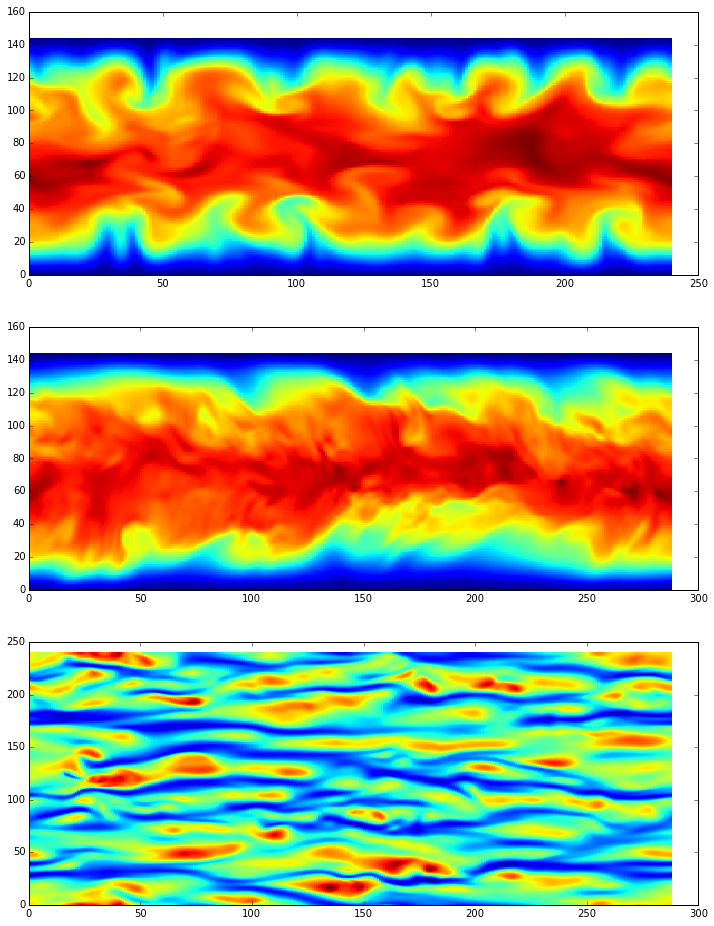

In [5]:
pl.figure(figsize=(12,16))
pl.subplot(311)
pl.pcolormesh(u[:,:,0])
pl.subplot(312)
pl.pcolormesh(u[:,0,:])
pl.subplot(313)
pl.pcolormesh(u[15,:,:])

# Processing the data with numpy
With `numpy` we can do many useful things. Numpy describes itself as: 
> *"NumPy is the fundamental package for scientific computing with Python.”*

One of them is applying operators. Let's start with something simple: computing the mean of our `numpy` `array` `u`:

In [6]:
u.mean()

0.022334896671238228

However, as atmospheric scientists, we are often interested in vertical profiles. For that we can specify along which dimension we want to take the mean. As we only want to retain our first dimension, we apply the mean along a dimension twice and print the output to the screen:

In [7]:
u_mean = u.mean(2).mean(1)

In [8]:
u_mean

array([ 0.00030791,  0.0009487 ,  0.001624  ,  0.00233514,  0.00308314,
        0.00386858,  0.00469139,  0.0055507 ,  0.00644466,  0.00737034,
        0.0083236 ,  0.00929908,  0.01029034,  0.01129   ,  0.01229003,
        0.01328214,  0.01425806,  0.01520998,  0.01613085,  0.01701475,
        0.01785721,  0.01865536,  0.01940801,  0.02011547,  0.0207791 ,
        0.0214009 ,  0.02198315,  0.02252829,  0.02303857,  0.02351569,
        0.02396104,  0.02437648,  0.02476496,  0.02513023,  0.02547651,
        0.02580807,  0.02612767,  0.02643523,  0.02672818,  0.02700293,
        0.0272568 ,  0.02748996,  0.02770633,  0.02791233,  0.02811445,
        0.02831684,  0.02852231,  0.02873322,  0.02895174,  0.02917942,
        0.02941245,  0.02964452,  0.02987231,  0.03009516,  0.03031377,
        0.0305347 ,  0.03076288,  0.030991  ,  0.03120739,  0.03140644,
        0.03159204,  0.03176996,  0.03194054,  0.03210724,  0.03227497,
        0.0324411 ,  0.03259607,  0.03272854,  0.03282814,  0.03

That went pretty well. We make a plot to have a preliminary look:

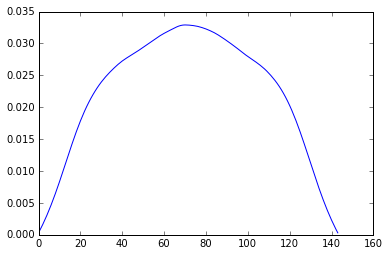

In [9]:
pl.plot(u_mean)

# Intermezzo: the speed of numpy
Numpy's functions are really fast, because they are optimized functions. Computing the mean of this large field almost goes instantaneously. We use the `time` module to measure the performance:

In [10]:
start = time.time()
u.mean(2).mean(1)
end = time.time()
speed_numpy = end - start
print("Elapsed time for numpy routine: {0} (s)".format(speed_numpy))

Elapsed time for numpy routine: 0.0382299423218 (s)


As most of you already know: do NOT loop in interpreted languages such as Python (or Matlab, or NCL, or ...)! Numpy has many functions around that can help you to avoid it. Let's measure how slow it is:

In [11]:
start = time.time()
u_mean2 = np.zeros(ktot)
for k in range(ktot):
    for j in range(jtot):
        for i in range(itot):
            u_mean2[k] += u[k,j,i]
u_mean2 /= (itot*jtot)
end = time.time()
speed_loop = end - start
print("Elapsed time for loop: {0} (s)".format(speed_loop))
print("Speedup numpy / loop: {0}".format(speed_loop / speed_numpy))

Elapsed time for loop: 10.6927878857 (s)
Speedup numpy / loop: 279.696678474


Now that is a speedup! Numpy is three orders of magnitude faster than a hand-written loop. Let us check if the results are the same:

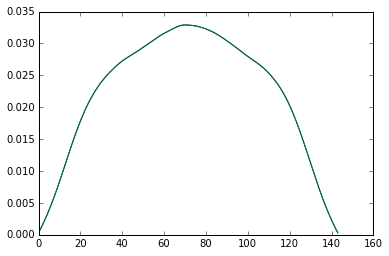

In [12]:
pl.plot(u_mean)
pl.plot(u_mean2)

# Working with NetCDF data
### Reading the data
Very much from the past, this binary data... Let us work with NetCDF data. We are going to load a statistics file now from the same simulation using the `NetCDF4` module. We use the `Dataset` function to open the file:

In [13]:
datafile_nc = nc.Dataset('moser180.default.0003600.nc')

With the `datafile_nc` variabe, we can access the file and retrieve a variable. We choose again for the variable `u`, which represents a timeseries of the vertical profile that we looked at before.

In [14]:
u_var = datafile_nc.variables['u']
print("The long name is: {0}".format(u_var.long_name))
print("The units are: {0}".format(u_var.units))

The long name is: U velocity
The units are: m s-1


### Plotting the data with the right dimensions and orientation
The last sample of the time series in the statistics represents the same data as our imported binary. Let us make sure that that is correct by plotting the data over each other:

In [15]:
u_mean3 = u_var[-1,:]

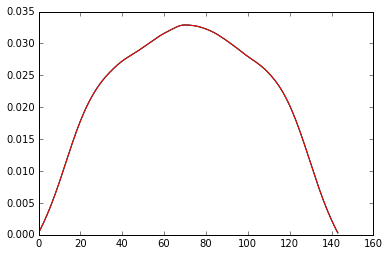

In [16]:
pl.plot(u_mean)
pl.plot(u_mean2)
pl.plot(u_mean3)

Our simulations have been done on a non-uniform grid in the vertical direction. We would like to plot our mean against the correct dimension and oriented vertically:

In [17]:
z = datafile_nc.variables['z'][:]

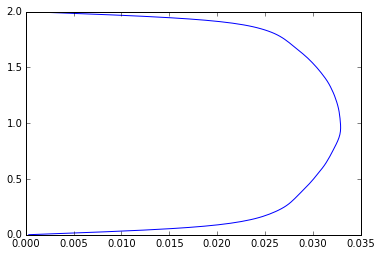

In [18]:
pl.plot(u_mean3, z)

# Visualizing statistical convergence
Now, let's plot the variance. We are looking at a steady state case, and we are interested in the statistical convergence of our results. The variance can be quite noisy, so we plot all our samples using a simple `for` loop in gray and subsequently the averaged profile, using the mean function we used before. In order to do so, we load the data of the time dimension from the NetCDF file.

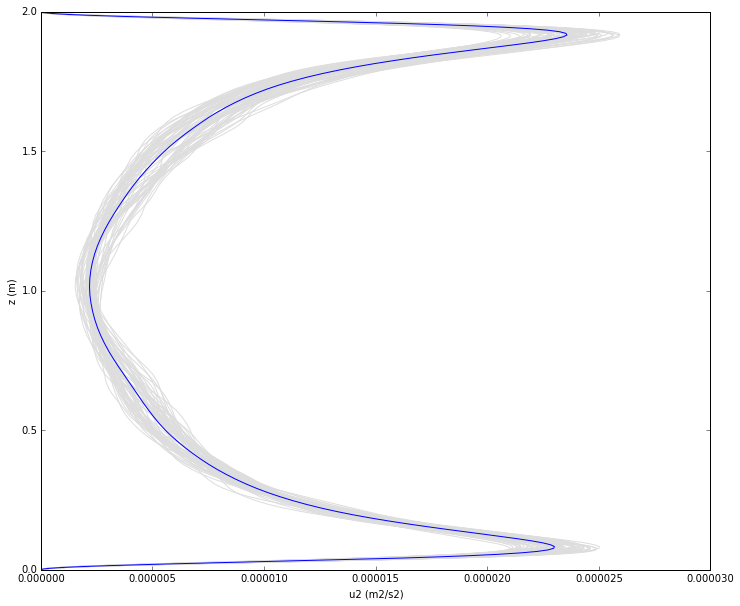

In [19]:
t = datafile_nc.variables['t'][:]
u2_var = datafile_nc.variables['u2']
figure(figsize(12,10))
for n in range(t.size):
    pl.plot(u2_var[n,:], z, color='#dddddd')
pl.plot(u2_var[:,:].mean(0),z)
xlabel('u2 (m2/s2)')
ylabel('z (m)')

### Last but not least: Towards publication quality - or - making your figures Bjorn-proof
We will now remake the previous figure using the techniques that have been shown in the introduction lecture. We use LaTeX, remove the right and top axes and write axis labels: 

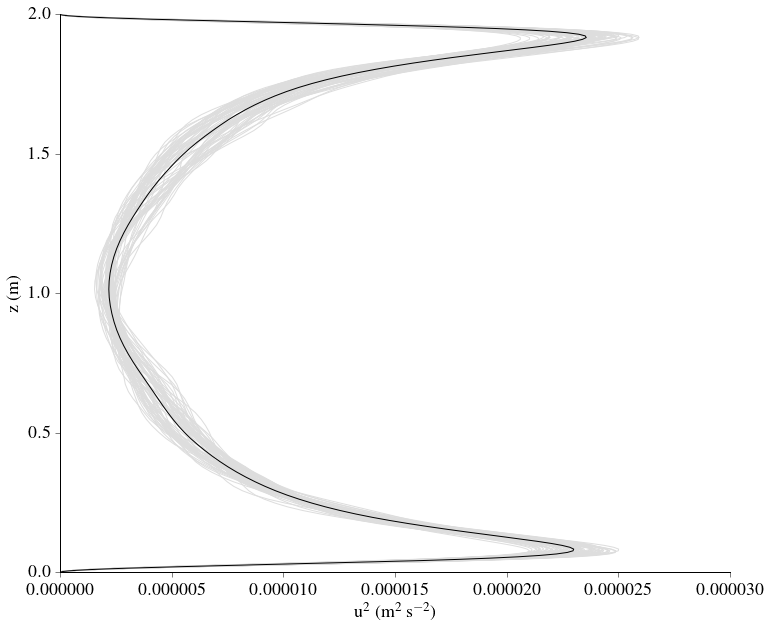

In [20]:
from matplotlib import rc
rc('text', usetex=True)
rc('font',**{'family':'serif','serif':['Times']})
rc('font', size=18)
rc('xtick', direction='out')
rc('ytick', direction='out')
rc('xtick.major', size=5)
rc('xtick.minor', size=2)
rc('ytick.major', size=5)
rc('ytick.minor', size=2)
pl.figure(figsize(12,10))
ax = pl.subplot(111)
for n in range(t.size):
    pl.plot(u2_var[n,:], z, color='#dddddd')
pl.plot(u2_var[:,:].mean(0), z, 'k-')
pl.xlabel(r'u$^2$ (m$^2$ s$^{-2}$)')
pl.ylabel(r'z (m)')
ax.spines['right'].set_visible(False)
ax.get_yaxis().tick_left()
ax.spines['top'].set_visible(False)
ax.get_xaxis().tick_bottom()